In [1]:
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim

In [4]:
path_to_dir = "/kaggle/input/enlarged-mnist-data-with-bounding-boxes/mnist_img_with_bb/mnist_img_with_bb"
path_to_csv_file = "/kaggle/input/enlarged-mnist-data-with-bounding-boxes/mnist_img_enlarged_bb.csv"

df = pd.read_csv(path_to_csv_file)

In [5]:
df.head()

,Unnamed: 0,name,target_label,height,width,x_min,x_max,y_min,y_max
0,0,5_0.png,5,28,28,18,46,18,46
1,1,0_1.png,0,28,28,37,65,37,65
2,2,4_2.png,4,28,28,15,43,15,43
3,3,1_3.png,1,28,28,38,66,38,66
4,4,9_4.png,9,28,28,42,70,42,70


In [6]:
train_data_df, test_data_df = train_test_split(df, test_size=0.2, random_state=42)
train_data_df, val_data_df = train_test_split(train_data_df, test_size=0.25, random_state=42)

print(len(train_data_df), len(val_data_df), len(test_data_df))

42000 14000 14000


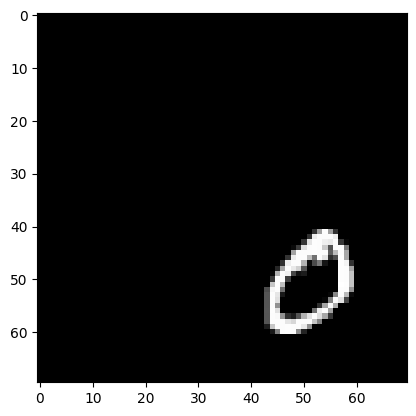

In [7]:
path_img = os.path.join(path_to_dir, "0", "0_1.png")
img = Image.open(path_img)
plt.imshow(img, cmap="gray")
plt.show()

In [8]:
class CustomDataset(Dataset):
    def __init__(self, path_to_dir, data, transform=None):
        super(CustomDataset, self).__init__()
        self.path_to_dir = path_to_dir
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        _, img_name, label, h, w, x, _, y, _ = self.data.iloc[idx]
        img_name = os.path.join(self.path_to_dir, str(label), img_name)
        img = Image.open(img_name)
        bbox = torch.tensor([x, y, w, h], dtype=torch.float32)

        if self.transform is not None:
            img = self.transform(img)
        return img, label, bbox

In [9]:
def prepare_data(path_to_dir, train_data, val_data, test_data, transform, batch_size=256):
    train_dataset = CustomDataset(path_to_dir, train_data, transform)
    val_dataset = CustomDataset(path_to_dir, val_data, transform)
    test_dataset = CustomDataset(path_to_dir, test_data, transform)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

In [10]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataloader, val_dataloader, test_dataloader = prepare_data(path_to_dir, train_data_df, val_data_df, test_data_df, transform)

In [11]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self, out_channels):
        super(CustomNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.max_pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max_pooling2 = nn.MaxPool2d(kernel_size=4, stride=4)

        self.batch_norm1 = nn.BatchNorm2d(num_features=16)
        self.batch_norm2 = nn.BatchNorm2d(num_features=64)

        self.fc1 = nn.Linear(in_features=64*8*8, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=128)
        
        self.classification_head = nn.Linear(in_features=128, out_features=out_channels)
        self.bbox_head = nn.Linear(in_features=128, out_features=4)
        

    def forward(self, x):
        x = self.conv2(self.conv1(x))
        x = self.batch_norm1(self.max_pooling1(x))
        x = F.relu(x)
        x = self.conv4(self.conv3(x))
        x = self.batch_norm2(self.max_pooling2(x))
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        class_logits = self.classification_head(x)
        bbox_coords = self.bbox_head(x)
        return class_logits, bbox_coords

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [48]:
out_channels = len(df["target_label"].unique())
print(f"out_channels = {out_channels}")
model = CustomNeuralNetwork(out_channels)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

classify_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn = nn.MSELoss()

out_channels = 10


In [49]:
def val_model(model, val_dataloader, classify_loss_fn, regression_loss_fn, optimizer, device):
    model.eval()
    model.to(device)
    total_val_loss = 0

    with torch.no_grad():
        for (img, label_target, bbox_target) in val_dataloader:
            img, label_target, bbox_target = img.to(device), label_target.to(device), bbox_target.to(device)
            
            label_out, bbox_out = model(img)
            classify_loss = classify_loss_fn(label_out, label_target)
            bbox_loss = regression_loss_fn(bbox_out, bbox_target)
            loss = classify_loss + bbox_loss
            total_val_loss += loss.item()
    return total_val_loss

In [50]:
def train_model(num_epochs, model, train_dataloader, val_dataloader, classify_loss_fn, regression_loss_fn, optimizer, device, path_to_save):
    model.train()
    model.to(device)
    train_losses = []
    val_losses = []
    min_loss = float("inf")
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        for (img, label_target, bbox_target) in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", unit="batch", colour="RED"):
            img, label_target, bbox_target = img.to(device), label_target.to(device), bbox_target.to(device)

            optimizer.zero_grad()
            
            label_out, bbox_out = model(img)
            classify_loss = classify_loss_fn(label_out, label_target)
            bbox_loss = regression_loss_fn(bbox_out, bbox_target)
            loss = classify_loss + bbox_loss
            
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        train_losses.append(total_train_loss)
        
        total_val_loss = val_model(model, val_dataloader, classify_loss_fn, regression_loss_fn, optimizer, device)
        val_losses.append(total_val_loss)

        if total_val_loss < min_loss:
            min_loss = total_val_loss
            torch.save(model.state_dict(), os.path.join(path_to_save, "best_model.pt"))
            
        torch.save(model.state_dict(), os.path.join(path_to_save, "last_model.pt"))
        print(f"train_loss = {total_train_loss:.5f}, val_loss = {total_val_loss:.5f}\n")   
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(path_to_save, "train_val_loss.png"), dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
train_model(30, model, train_dataloader, val_dataloader, classify_loss_fn, regression_loss_fn, optimizer, device, path_to_save="/kaggle/working/")

In [53]:
best_model = CustomNeuralNetwork(out_channels)
path_to_save = "/kaggle/working/"
best_model.load_state_dict(torch.load(os.path.join(path_to_save, "best_model.pt"),  map_location=device))

/tmp/ipykernel_30/410489010.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(os.path.join(path_to_save, "best_model.pt"),  map_locat

<All keys matched successfully>

In [64]:
def convert_to_corner(bbox):
    xmin = bbox[:, 0]
    ymin = bbox[:, 1]
    xmax = xmin + bbox[:, 2]
    ymax = ymin + bbox[:, 3]
    return torch.stack([xmin, ymin, xmax, ymax], dim=1)
    
def compute_IoU(box1, box2):
    x1 = torch.max(box1[:, 0], box2[:, 0])
    y1 = torch.max(box1[:, 1], box2[:, 1])
    x2 = torch.min(box1[:, 2], box2[:, 2])
    y2 = torch.min(box1[:, 3], box2[:, 3])

    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = area1 + area2 - intersection

    return intersection / torch.clamp(union, min=1e-6)

In [86]:
def get_accuracy(model, val_dataloader, device, iou_threshold=0.5):
    model.eval()
    model.to(device)
    TP, FP, FN = 0, 0, 0
    with torch.no_grad():
        for (img, label_target, bbox_target) in val_dataloader:
            img, label_target, bbox_target = img.to(device), label_target.to(device), bbox_target.to(device)
            
            label_out, bbox_out = model(img)
            bbox_out = convert_to_corner(bbox_out)
            bbox_target = convert_to_corner(bbox_target)     
            
            IoUs = compute_IoU(bbox_out, bbox_target)
            label_predict = torch.argmax(label_out, dim=1)
            
            TP += (IoUs >= iou_threshold) & (label_predict == label_target).sum().item()
            FP += ((IoUs < iou_threshold) | (label_predict != label_target)).sum().item()
            FN += ((IoUs < iou_threshold) & (label_predict == label_target)).sum().item()
            
    accuracy = TP / (TP + FP + FN)
    return accuracy

In [ ]:
def find_best_threshold(model, val_dataloader, device, min=30, max=71):
    accuracy_arr = []
    best_accuracy = 0
    best_iou = None
    for i in tqdm(range(min, max+1, 1), colour="red"):
        iou_threshold = i / 100
        accuracy = 100 * get_accuracy(model, val_dataloader, device, iou_threshold=iou_threshold)
        accuracy_arr.append(accuracy)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_iou = iou_threshold

    threshold_arr = range(min, max+1)

    plt.figure(figsize=(15, 5))
    plt.plot(threshold_arr, accuracy_arr, label='Validation Accuracy ', marker='o')
    plt.plot(best_iou, best_accuracy, 'ro', markersize=10, label='Best accuracy')
    plt.title('Accuracy according to IoU-threshold')
    plt.xlabel('IoU')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.show()

    print(f"IoU = {best_iou} for best Val_accuray = {best_accuracy:.4f}%")
    return best_iou

100%|██████████| 42/42 [12:02<00:00, 17.20s/it]


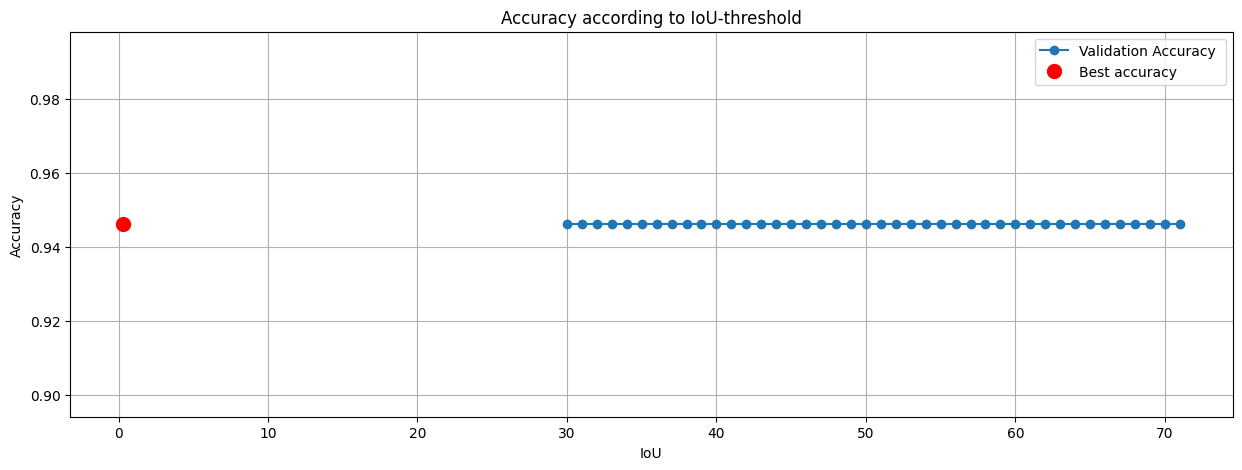

IoU = 0.3 for best Val_accuray = 0.9462%


In [101]:
best_iou = find_best_threshold(best_model, val_dataloader, device)

In [102]:
print(f"Accuracy on test set: {100 * get_accuracy(best_model, test_dataloader, device, best_iou):.4f}%")

Accuracy on test set: 94.4143%


In [176]:
def visulize_some_samples(model, test_dataloader, device, idx=50):
    with torch.no_grad():
        for (img, label_target, bbox_target) in test_dataloader:
            img, label_target, bbox_target = img.to(device), label_target.to(device), bbox_target.to(device)
        
            img_subset = img[idx:idx+8]
            bbox_target_subset = bbox_target[idx:idx+8]
        
            label_out, bbox_out = model(img_subset)
            label_predicted = torch.argmax(label_out, dim=1)

            IoUs = compute_IoU(convert_to_corner(bbox_target_subset), convert_to_corner(bbox_out))

            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes = axes.flatten()

            for i in range(8):
                ax = axes[i]
                img_np = img_subset[i].cpu().numpy().transpose(1, 2, 0)
                ax.imshow(img_np, cmap="gray")
        
                bboxes = bbox_out[i].cpu().numpy() 
                bboxes_target = bbox_target_subset[i].cpu().numpy() 
                
                x_target, y_target, w_target, h_target = bboxes_target
                # x_target, y_target, w_target, h_target = int(x_target), int(y_target), int(w_target), int(h_target)
                
                rect1 = plt.Rectangle((x_target, y_target), w_target, h_target, fill=False, color='green', linewidth=2)
                ax.add_patch(rect1)
                
                x, y, w , h = bboxes
                # x, y, w, h = int(x), int(y), int(w), int(h)
                rect2 = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
                ax.add_patch(rect2)
                
                predicted_label = label_predicted[i].cpu().numpy()
                ax.text(x+w/3, y-0.5, f"Predicted: {predicted_label}", color='white', fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
                ax.text(x+w/3, y+h, f"IoU = {IoUs[i]:.3f}", color='white', fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

                ax.axis('off')
    
            plt.tight_layout()
            plt.show()
            break

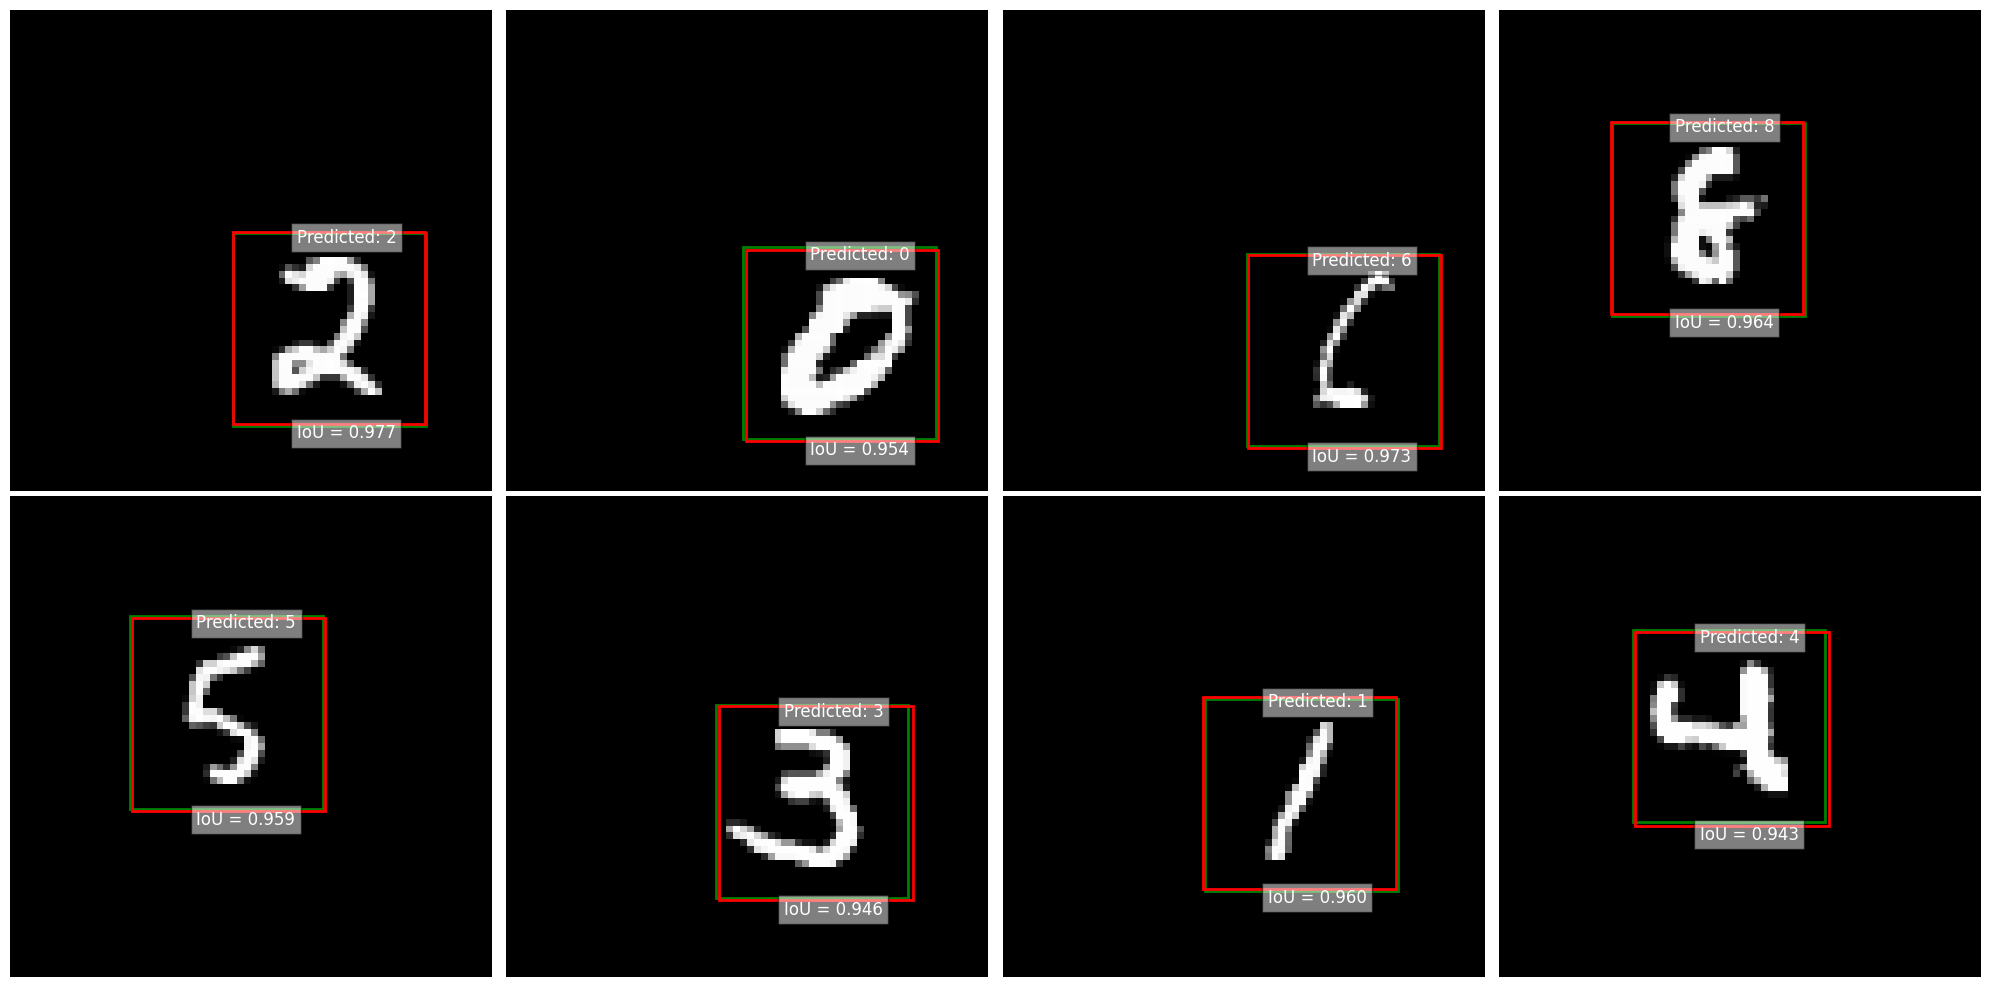

In [177]:
visulize_some_samples(best_model, test_dataloader, device)